# Part 1

Use the rate given by equation 2.1 with $r_0 = 50$ Hz and

$$
D(\tau) = -\cos \left( \frac{2 \pi (\tau - 20 \, \text{ms})}{140 \, \text{ms}} \right) \exp \left( -\frac{\tau}{60 \, \text{ms}} \right)
$$

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus. The above equation is an approximation for the linear kernel obtained from the spike-triggered average shown in figure 1.9. Use an approximate Gaussian white noise stimulus constructed by choosing a stimulus value every 10 ms ($\Delta t = 10$ ms) from a Gaussian distribution with zero mean and variance $\sigma_s^2 /\Delta t$, with $\sigma_s^2 = 10$. Compute the firing rate over a 10 s period. From the results, compute the firing rate-stimulus correlation function $Q_{rs}(\tau)$. Using equation 2.6, compare $Q_{rs}(-\tau)/\sigma_s^2$ with the kernel $D(\tau)$ given above.

In [25]:
# Import the necessary packages
import matplotlib.pyplot as plt # Plotting
import numpy as np # Maths + stats applications 
import pandas as pd # Handling data
import scipy.signal # A little more niche, very specific maths + stats applications 
import scipy.stats

# For replicability
np.random.seed(101)

# Exercise 1_1
# Here we will use the equation r_est(t) = r_0 + integral (D (tau) * s(t - tau))

# Initial setup
r_0 = 50 # Hz 
dt = 0.01 # Time step

# The variance of the white noise should be 10/0.01 or 1000
STD_s = np.sqrt(10/dt) # STD of the Gaussian stimulus generator
time_vector = np.arange(0, 10, dt) # Time vector

# Generate the vector of stimuli
s = np.random.normal(0, STD_s, len(time_vector))

# Generature the vector of values for the kernel 
D_list = []
for tau in time_vector:
    D_list.append(-np.cos( (2*np.pi*(tau-0.02))/(0.14)) * np.exp(-tau/0.06))

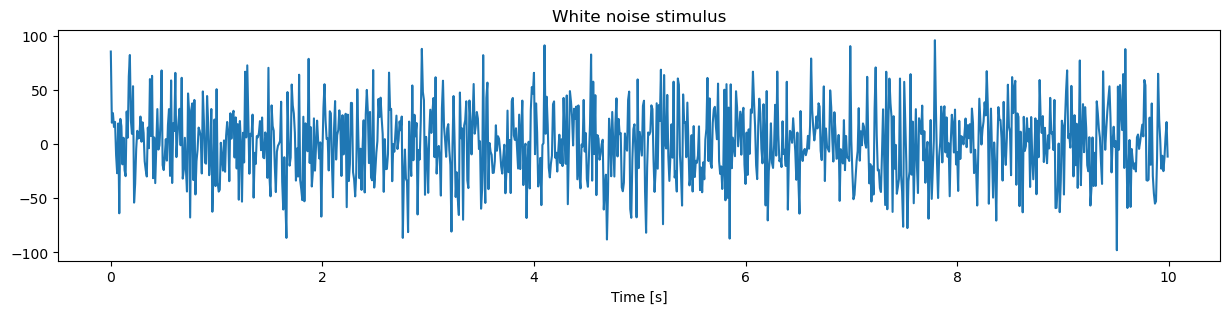

In [3]:
# Make sure we got the stimulus right, it should fluctuate around 0 and for the most part stay within
# the ± square root of 10 (~3.2). It's always a good practice to visualise the inputs! 

plt.figure(figsize=(15, 3))
plt.plot(time_vector, s)
plt.title("White noise stimulus")
plt.xlabel("Time [s]")
plt.show()

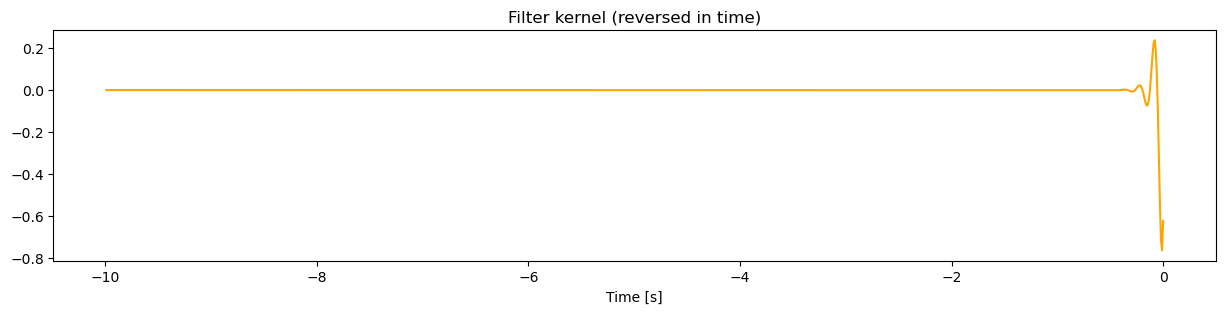

In [4]:
# Here we plot the (reversed) filter kernel in negative time, meaning the stimulus value x many ms before
# the time in question wil affect the firing rate. This effect extends only about 100-200 ms into the past
plt.figure(figsize=(15, 3))
plt.plot(-time_vector[::-1], D_list[::-1], color="orange")
plt.title("Filter kernel (reversed in time)")
plt.xlabel("Time [s]")
plt.show()

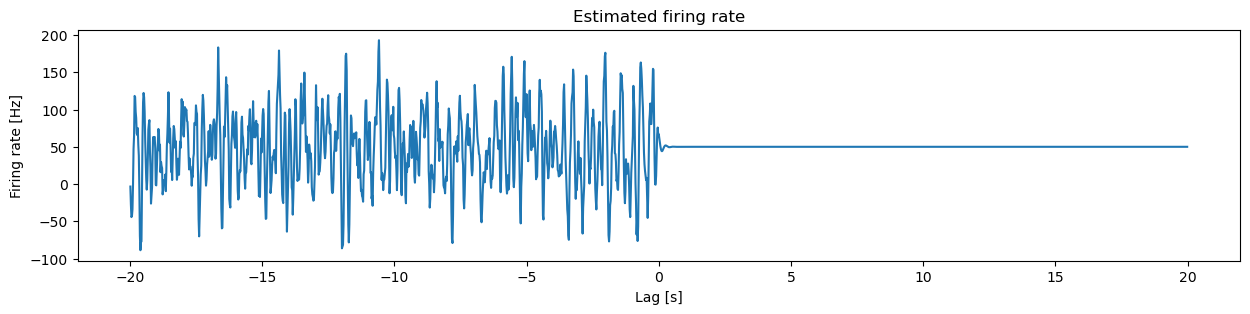

In [137]:
# Perform reverse correlation, add baseline. Convolution is commutative so the order of arguments doesn't 
# matter
convolved_D_s_w_r0 = np.convolve(D_list, s, mode='full') + r_0
lags_RS = np.arange(-len(D_list)+1, len(D_list))*dt*10 # The *10 converts it to seconds

# Plot the entire convolution as a function of tau
plt.figure(figsize=(15, 3))
plt.plot(lags_RS, convolved_D_s_w_r0)
plt.title("Estimated firing rate")
plt.xlabel("Lag [s]")
plt.ylabel("Firing rate [Hz]")
plt.show()


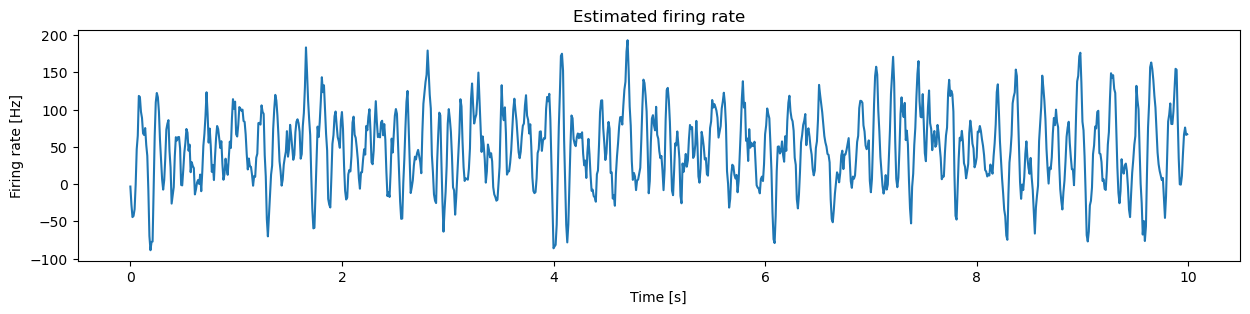

In [138]:
# Only extract meaningful data points, that is, the first half. That is the r_est as a function of time
r_est = convolved_D_s_w_r0[:int(np.ceil(len(convolved_D_s_w_r0)/2))]

plt.figure(figsize=(15, 3))
plt.plot(time_vector, r_est)
plt.title("Estimated firing rate")
plt.xlabel("Time [s]")
plt.ylabel("Firing rate [Hz]")
plt.show()

It's worth noting here that the firing rate obviously cannot be negative. We could introduce a static non-linearity to correct this, bbut the exercise does not explicitly ask for this

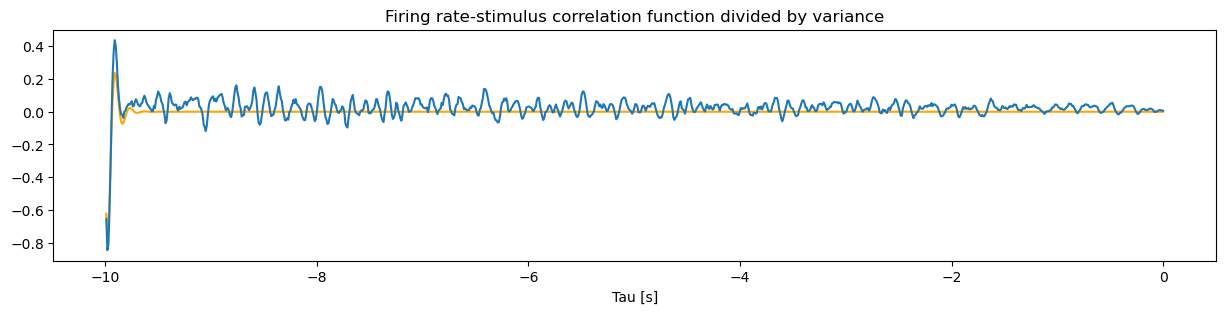

In [7]:
# Empirical firing rate-stimulus correlation function, make sure to divide by the length T
Q_rs_emp = np.correlate(s, r_est, mode='full')/(len(r_est))

# Now we have obtained the cross-correlation Q_rs as a function of tau. We are only interested in the 
# first half of the values though, just like above. Then we mustn't forget to divide by the sigma squared and
# plot it in reverse time 
Q_rs_emp_cor = Q_rs_emp[:int(np.ceil(len(Q_rs_emp)/2))]/STD_s**2

plt.figure(figsize=(15, 3))
plt.plot(-time_vector[::-1], D_list, color="orange")
plt.plot(-time_vector[::-1], Q_rs_emp_cor[::-1])
# plt.plot(time_vector, D_list)
plt.title("Firing rate-stimulus correlation function divided by variance")
plt.xlabel("Tau [s]")
plt.show()

# Part 2

matlab® file c1p8.mat contains the data described in exercise 8 of chapter 1. Use the spike-triggered average (calculated in that exercise) to construct a linear kernel and use it in equation 2.1 to provide a model of the response of the H1 neuron. Choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate. Use a Poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus stim. Plot examples of the actual and synthetic spike trains. How are they similar and how do they differ? Plot the autocorrelation function of the actual and the synthetic spike trains over the range 0 to 100 ms. Why is there a dip at a lag of 2 ms in the autocorrelation of the actual spike train? Is there a dip for the synthetic train too? Plot the interspike interval histogram for both spike trains. Why is there a
dip below 6 ms in the histogram for the actual spike train? What are the coefficients of variation for the two spike trains and why might they differ? (Based on a problem from Sebastian Seung).

This is quite a long task. Let's break it down piece by piece, starting with this portion:

Use the spike-triggered average (calculated in that exercise) to construct a linear kernel and use it in equation 2.1 to provide a model of the response of the H1 neuron. Choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate.

In [4]:
# Load the said STA
STA_H1ex8 = np.load("STA_H1ex8.npy")

In [5]:
# Also load the original data:
P8_data = pd.read_csv("C1P8.csv", header=None)

# Rename the columns for clarity 
P8_data.rename(columns={0: "Rho", 1: "Stim"}, inplace=True)

# Preview
P8_data.head()

,Rho,Stim
0,0,-111.948242
1,0,-81.806641
2,0,10.219727
3,0,83.364258
4,0,69.375000


In [6]:
# Construct a linear kernel, we can use the equation 2.6 from the book wherein the linear kernel is equal 
# to the STA multiplied by the average firing rate and divided by the variance of the stimulus, see page 47

# The variance (obtained from last chapter) of the white noise stimulus was:
var_s = 5.107

# And the average firing rate was: 
avg_r = 44.66 # Hz

dt2 = 0.002

time_vector2 = np.arange(0, 20*60, dt2)

In [7]:
# In line with the notation of the book, D refers to kernel and D2 just means kernel used in Part 2 
D2 = (STA_H1ex8[0:round(len(STA_H1ex8)/2)] * avg_r) / var_s
D2 = D2[::-1]

# D2 is 600000 time points long (20 min at 2 ms dt), but our s was only 10 seconds long. We need to generate 
# a longer stimulus

# Generate the vector of stimuli
s2 = np.random.normal(0, STD_s, len(time_vector2))

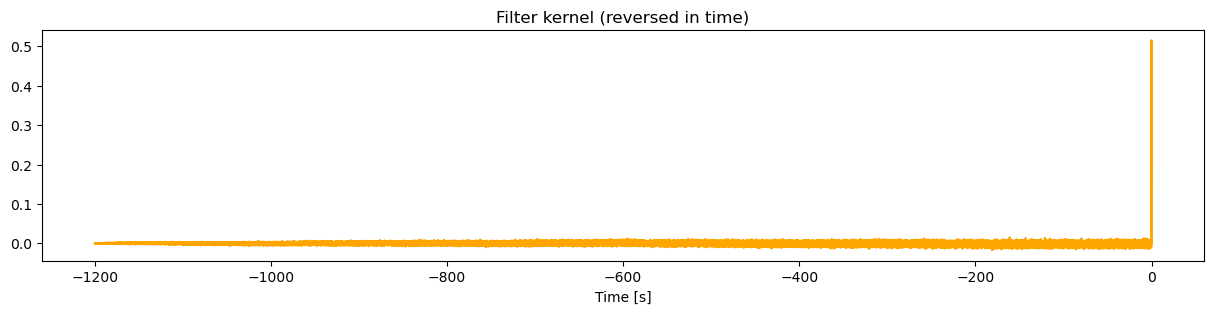

In [8]:
# Here we plot the (reversed) filter kernel in negative time, meaning the stimulus value x many ms before
# the time in question wil affect the firing rate. This effect extends only about 100-200 ms into the past
plt.figure(figsize=(15, 3))
plt.plot(-time_vector2[::-1], D2[::-1], color="orange")
plt.title("Filter kernel (reversed in time)")
plt.xlabel("Time [s]")
plt.show()

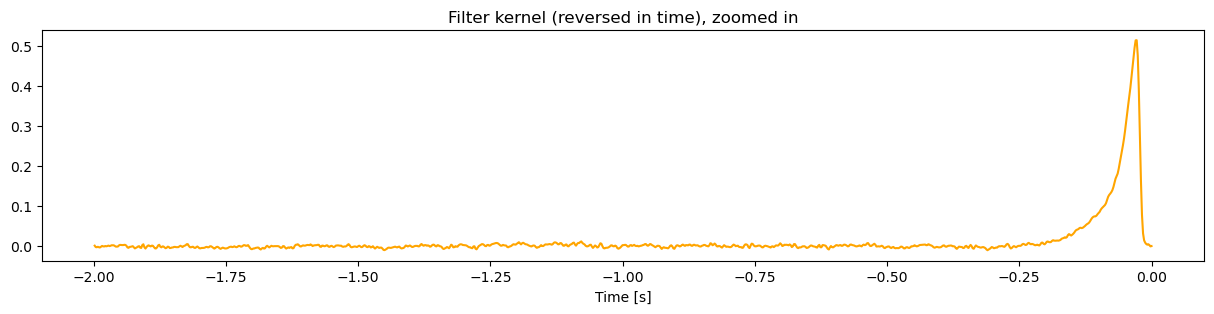

In [9]:
# Let's zoom in a little
plt.figure(figsize=(15, 3))
plt.plot(-time_vector2[0:1000][::-1], D2[0:1000][::-1], color="orange")
plt.title("Filter kernel (reversed in time), zoomed in")
plt.xlabel("Time [s]")
plt.show()

In [10]:
# Now to create the firing rate estimate. NB: This takes a pretty long time!
# We are only doing this to  
EFR2 = np.convolve(D2, s2, mode='full')

Text(0.5, 1.0, 'Estimated firing rate')

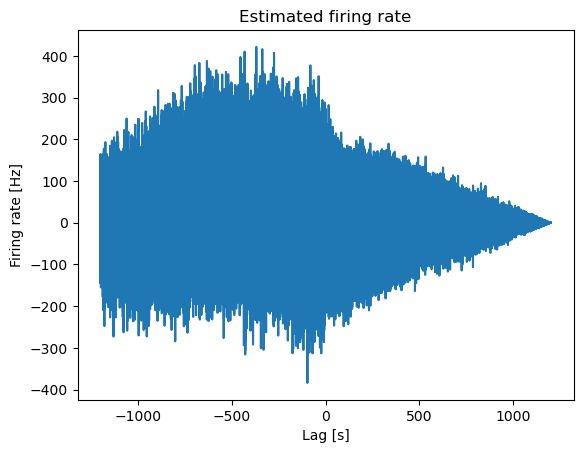

In [11]:
# We can visualise what the predicted. 
lags_RS_2 = np.arange(-len(D2)+1, len(D2))*dt2
plt.plot(lags_RS_2, EFR2)
plt.ylabel("Firing rate [Hz]")
plt.xlabel("Lag [s]")
plt.title("Estimated firing rate")

In [12]:
# Extract the estimate firing rate and subtract it from the actual averge. This will give us our r0
r0_2 = avg_r-(EFR2[:int(len(EFR2)/2)]).mean()

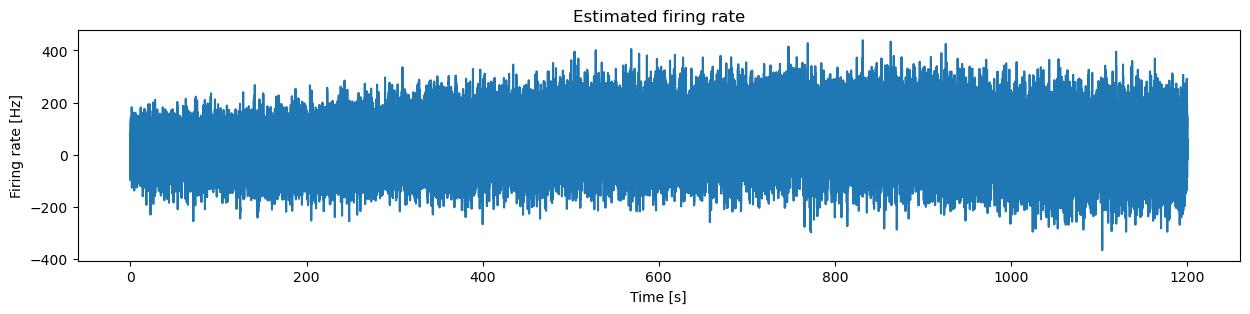

In [13]:
# Plot the final correct estimated firing rate 
convolved_D_s_w_r02 = np.convolve(D2, s2, mode='full') + r0_2
r_est2 = convolved_D_s_w_r02[:int(np.ceil(len(convolved_D_s_w_r02)/2))]

plt.figure(figsize=(15, 3))
plt.plot(time_vector2, r_est2)
plt.title("Estimated firing rate")
plt.xlabel("Time [s]")
plt.ylabel("Firing rate [Hz]")
plt.show()

In [14]:
# Empirical firing rate-stimulus correlation function, make sure to divide by the length of trial or T
Q_rs_emp = np.correlate(s2, r_est2, mode='full')/(len(r_est2))

# Now we have obtained the cross-correlation Q_rs as a function of tau. We are only interested in the 
# first half of the values though, just like above. Then we mustn't forget to divide by the sigma squared and
# plot it in reverse time 
Q_rs_emp_cor = Q_rs_emp[:int(np.ceil(len(Q_rs_emp)/2))]/STD_s**2


Text(0, 0.5, 'Firing rate [Hz]')

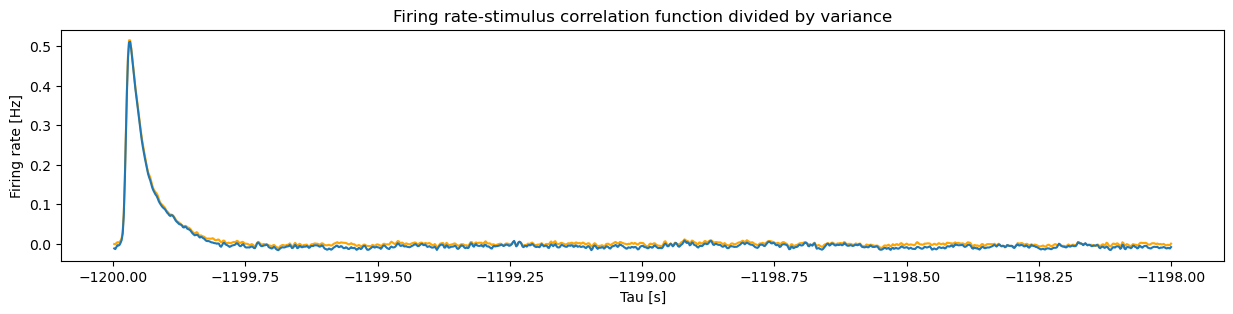

In [15]:
plt.figure(figsize=(15, 3))
plt.plot(-time_vector2[::-1][:1000], D2[:1000], color="orange")
plt.plot(-time_vector2[::-1][:1000], Q_rs_emp_cor[::-1][:1000])

plt.title("Firing rate-stimulus correlation function divided by variance")
plt.xlabel("Tau [s]")
plt.ylabel("Firing rate [Hz]")

# This is just to make sure we are doing everything correctly so far (it's a really good match!)

The next part of the task:

Use a Poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus "stim". Plot examples of the actual and synthetic spike trains. How are they similar and how do they differ?

In [16]:
# First, we need to rectify the estimated firing rate because it can't be negative

r_est2_copy = r_est2

r_est2_copy[r_est2_copy < 0] = 0
r_est2_copy = r_est2_copy.tolist()
spikes_synthetic = []

for time_point in range(len(r_est2_copy)):
    spikes_synthetic.append(np.random.poisson(lam=r_est2_copy[time_point]*dt2, size=1)[0])

spikes_synthetic = np.array(spikes_synthetic)
    
spikes_synthetic[spikes_synthetic > 1] = 1

Text(0.5, 1.0, 'Synthetic spike train')

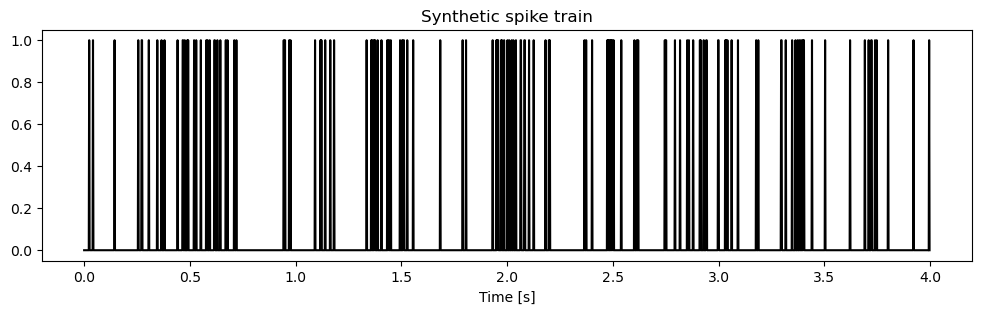

In [17]:
# If we visualised the spike train over the course of the 1200 seconds, it would just be a black rectangle, 
# 4 seconds will suffice 

plt.figure(figsize = (12, 3))
plt.plot(time_vector2[:2000], spikes_synthetic[:2000], "k")
plt.xlabel("Time [s]")
plt.title("Synthetic spike train")

Text(0.5, 1.0, 'True spike train')

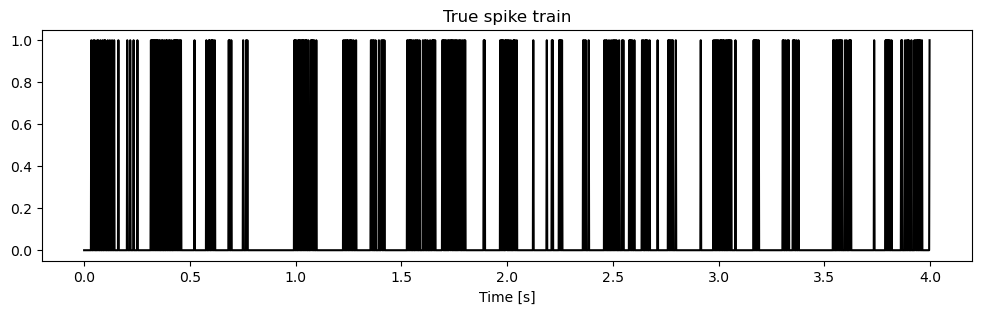

In [18]:
# And now the true spikes
plt.figure(figsize = (12, 3))
plt.plot(time_vector2[:2000], P8_data.Rho[:2000], "k")
plt.xlabel("Time [s]")
plt.title("True spike train")

To my eye, there are more clearly defined "bursting" periods in the true spike train whereas the synthetic spikes are more spread out. However, these periods of halcyon and burts are somewhat present in the synthetic spike train as well

Next up: 

Plot the autocorrelation function of the actual and the synthetic spike trains over the range 0 to 100 ms. Why is there a dip at a lag of 2 ms in the autocorrelation of the actual spike train? Is there a dip for the synthetic train too?

In [19]:
autocor_syn = np.correlate(spikes_synthetic, spikes_synthetic, mode='full')/len(spikes_synthetic)

In [20]:
autocor_true = np.correlate(P8_data.Rho, P8_data.Rho, mode='full')/len(P8_data.Rho)

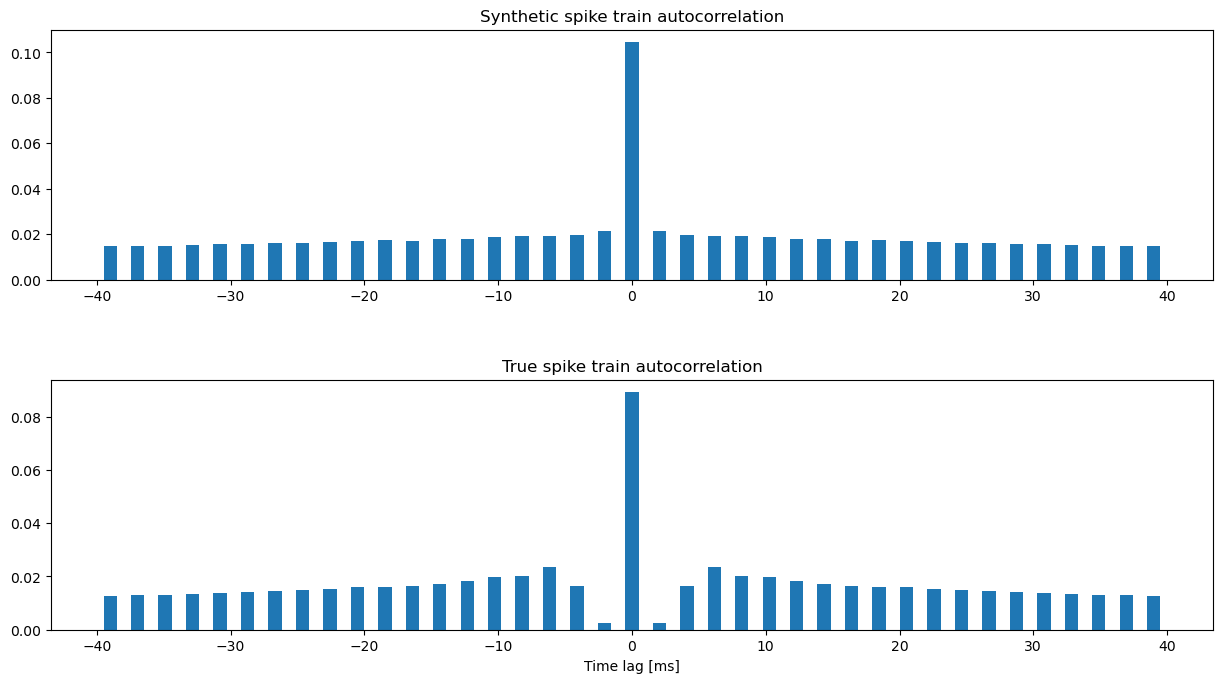

In [21]:
fig, axs = plt.subplots(2, figsize=(15, 4))

autocor_syn_tr = autocor_syn[int(np.floor(len(autocor_syn)/2))-19:int(np.floor(len(autocor_syn)/2))+20]
autocor_true_tr = autocor_true[int(np.floor(len(autocor_true)/2))-19:int(np.floor(len(autocor_true)/2))+20]
x1 = np.linspace(-len(autocor_syn_tr)/2, len(autocor_syn_tr)/2, len(autocor_syn_tr))*dt2*1000

# Plot all three figures together 
axs[0].bar(x1, autocor_syn_tr, width=dt2/2*1000)
axs[0].set_title("Synthetic spike train autocorrelation")
axs[1].bar(x1, autocor_true_tr, width=dt2/2*1000)
axs[1].set_title("True spike train autocorrelation")
axs[1].set_xlabel("Time lag [ms]")

plt.subplots_adjust(bottom=0.1,
                    top=1.6,
                    wspace=0.4,
                    hspace=0.4)

The dip at the 2 ms lag can be explained by the fact that there is, in real neurons, a refractory priod which prevents them from firing right after they spiked (and we only sampled every 2 ms). This has to do with the inactivation of sodium channels, as far as I know mostly around the axon initial segment. However, we did not include a refractory period in the Poisson generator so there is no such dip. 

Lastly:

Plot the interspike interval histogram for both spike trains. Why is there a
dip below 6 ms in the histogram for the actual spike train? What are the coefficients of variation for the two spike trains and why might they differ?

In [22]:
# Obtain the spike times
spike_times_syn = time_vector2[spikes_synthetic == 1]
spike_times_true = time_vector2[P8_data.Rho == 1]

# Generate the inter-spike interval data
t_isi_s = np.diff(spike_times_syn)
t_isi_t = np.diff(spike_times_true)

In [73]:
a = t_isi_s*1000

In [74]:
scipy.stats.variation(a)

1.7545985131568251

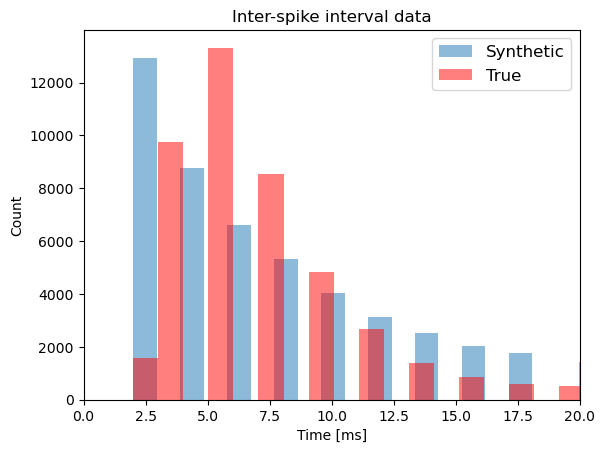

In [61]:
# Plot the inter-spike interval data
plt.hist(t_isi_s*1000, bins=600, alpha=0.5)
plt.hist(t_isi_t*1000, bins=600, alpha=0.5, color="r")
plt.xlim(left=0, right=20)
plt.title("Inter-spike interval data")
plt.xlabel("Time [ms]")
plt.ylabel("Count")
list2 = ["Synthetic", "True"]
plt.legend(list2, loc='upper right', fontsize=12)

In [62]:
# The ISI follows an exponential distribution for the synthetic spikes but it has a notable gap for the real 
# train. This is because of the refractory period in real neurons

In [85]:
print(f"The coefficient of variation (CV) of the synthetic spike train is {scipy.stats.variation(t_isi_s):.3f} " +
      f"whereas it takes the value {scipy.stats.variation(t_isi_t):.3f} for the true spike train. Because CV " +
      f"is higher for the real data, it speaks to more variability in the spikes as a function of the " +
      f"stimulus")

The coefficient of variation (CV) of the synthetic spike train is 1.755 whereas it takes the value 2.009 for the true spike train. Because CV is higher for the real data, it speaks to more variability in the spikes as a function of the stimulus


# Part 3

matlab® file c2p3.mat contains the responses of a cat LGN cell to two-dimensional visual images (these data are described in Kara, P, Reinagel, P, & Reid, RC (2000) Low response variability in simultaneously recorded retinal, thalamic, and cortical neurons. Neuron 30:803-817 and were kindly provided by Clay Reid). In the file, counts is a vector containing the number of spikes in each 15.6 ms bin, and stim contains the 32767, 16 × 16 images that were presented at the corresponding times. Specifically, stim(x, y, t) is the stimulus presented at the coordinate (x,y) at time-step t. Note that stim is an int8 array that must to be converted into double using the command stim=double(stim) in order to be manipulated within matlab®. Calculate the spike-triggered average images for each of the 12 time steps before each spike and show them all (using the imagesc command). Note that in this example, the time bins can contain more than one spike, so the spike-triggered average must be computed by weighting each stimulus by the number of spikes in the corresponding time bin, rather than weighting it by either 1 or 0 depending on whether a spike is present or not. In the averaged images, you should see a central receptive field that reverses sign over time. By summing up the images across one spatial dimension, produce a figure like that of figure 2.25C. (Based on a problem from Sebastian Seung.)